This is part 1. Read this before reading Tag Association and Comparison with Peer Prediction.

So my first approach for a predictor of rating was as follows: For each user, find any correlation between their ratings of films and other users’ ratings of films, with the idea that if two people show a strong correlation between their ratings of films,  then if person one has seen a film that person two has not, it is likely that if person one likes it then person two will also (and of course if person one did not like it then person two would also not like it).

In [1]:
library(plyr)
library(ggplot2)

movies <- read.csv("C:/Users/matt/Downloads/ml-20m/ml-20m/movies.csv",stringsAsFactors = FALSE)
#genomeScores <- read.csv("C:/Users/matt/Downloads/ml-20m/ml-20m/genome-scores.csv",stringsAsFactors = FALSE)
#genomeTags <- read.csv("C:/Users/matt/Downloads/ml-20m/ml-20m/genome-tags.csv",stringsAsFactors = FALSE)
#links <- read.csv("C:/Users/matt/Downloads/ml-20m/ml-20m/links.csv",stringsAsFactors = FALSE)
#tags <- read.csv("C:/Users/matt/Downloads/ml-20m/ml-20m/tags.csv",stringsAsFactors = FALSE)

In [2]:

#ratings <- read.csv("C:/Users/matt/Downloads/ml-20m/ml-20m/ratings.csv",stringsAsFactors = FALSE)
#randomRatings <- ratings[sample(nrow(ratings)),]
#trainingRatings <- randomRatings [1:16000000,]
#testRatings <- randomRatings [16000001:nrow(randomRatings),]
#write.table(trainingRatings,"C:/temp/trainingRatings.txt")
#write.table(testRatings,"C:/temp/testRatings.txt")


#testRating <- read.table("C:/temp/testRatings.txt")


Randomised the order of the ratings.csv file, then saved the first 16 million to a training file and the remaining roughly 4 million to a test file. Commented out here so that it doesn't need to be randomised again.

In [3]:
#trainRating <- read.table("C:/temp/trainingRatings.txt")
#powerUsers <- ((subset(as.data.frame(table(trainRating$userId)), Freq > 2500))$Var1)

#powerUserRatings <- subset(trainRating, userId %in% powerUsers)
#write.table(powerUserRatings, "C:/temp/poweruserRatings.txt")

powerUserRatings <- read.table("C:/temp/poweruserRatings.txt", stringsAsFactors = FALSE)

From here on I'm only looking at the users who have rated more than 2500 films, which I call 'power users'. Of course the analysis done here could be applied to users with fewer reviews, but for the interest of speeding up the processes this is sufficient.

powerUserRatings is the training set, where powerUserTestRatings will be the test set.

In [4]:
powerUsers <- unique(powerUserRatings$userId)
length(powerUsers)

[1] 48

rather than create a Peer model for the entire userbase, I instead focused on the users with the most views, in this case those who had reviewed over 2,500 films. 

In [5]:


correlatedPairs <- ddply(powerUserRatings, .(userId), function(x)
{
	MoviesForX = subset(movies, movieId %in% x$movieId)
	return(ddply(powerUserRatings, .(userId), function(y)
	{
		#print(paste(x$userId[1], y$userId[1]))
		if (y$userId[1] == x$userId[1])return(NULL)
		moviesInCommon = subset(MoviesForX, movieId %in% y$movieId)
		if (nrow(moviesInCommon) < 5)return (NULL)
		
		xInCommon = rename(subset(x, movieId %in% y$movieId), c("rating"="xRating","userId"="xUserId"))
		yInCommon = rename(subset(y, movieId %in% x$movieId), c("rating"="yRating","userId"="yUserId"))
		
		BothInCommon = merge(xInCommon[c("xUserId","movieId","xRating")], yInCommon[c("yUserId","movieId","yRating")])
		linearFit=summary(lm(BothInCommon, formula=xRating~yRating))
		return(data.frame(xUser = x$userId[1], yUser = y$userId[1],constant = linearFit$coefficients[1,1], linearCoeff =linearFit$coefficients[2,1] ))
	}
	))
})

In [6]:
head(correlatedPairs)

userId,xUser,yUser,constant,linearCoeff
8963,8405,8963,2.3891690,0.3983210
9544,8405,9544,0.9443728,0.8364734
12131,8405,12131,1.5113024,0.6066688
14705,8405,14705,1.6320663,0.6520435
15617,8405,15617,1.1502660,0.7353013
18138,8405,18138,1.0348831,0.7787809


Here the linearCoeff and constant are the coefficients in y=ax+b, respectively,for the linear fit.

I used a linear predictor here because it seems reasonable to assume that there is a strictly linear correlation between two users’ ratings. In theory at least, a 5 star rating system should be linear. In practice, of course, the difference between a 4.5 and 5 is different to the difference between a 1.5 and a 2, so while this doesn’t hold entirely, it seems to me a fair approximation to treat them as linear. There is also evidence of a bias against giving half star ratings in this data set. For example, of ratings given at 3, 3.5 or 4, only 18% were given as 3.5. Again this is another failing of the rating system, but something I’m going to overlook for now.

In [7]:
MovieList <- split(powerUserRatings,f=powerUserRatings$movieId)
names(MovieList) <- unique(powerUserRatings[order(powerUserRatings$movieId),]$movieId)

Puts the powerUserRatings into a list so that I can more quickly call the subsets with a specific user.

In [8]:
weighted.var <- function(x, w, na.rm = FALSE) {
    if (na.rm) {
        w <- w[i <- !is.na(x)]
        x <- x[i]
    }
    sum.w <- sum(w)
    sum.w2 <- sum(w^2)
    mean.w <- sum(x * w) / sum(w)
    (sum.w / (sum.w^2 - sum.w2)) * sum(w * (x - mean.w)^2, na.rm =
na.rm)
}

Code to calculated a weighted variance.

In [9]:
linearFitsList <- split(correlatedPairs, f=correlatedPairs$xUser)
names(linearFitsList) <- unique(correlatedPairs[order(correlatedPairs$xUser),]$xUser)

In [10]:


RatingPrediction <- function(TargetId, FilmId)
{
linearFits = linearFitsList[[as.character(TargetId)]]#subset(correlatedPairs, xUser==TargetId)
numberOfReviews = 0
scores=NULL
weights = NULL
trainingDataOnFilm = MovieList[[as.character(FilmId)]]
if (!is.null(trainingDataOnFilm ))
    {
    trainingDataList <- split(trainingDataOnFilm,f=trainingDataOnFilm$userId)
    names(trainingDataList) <- unique(trainingDataOnFilm[order(trainingDataOnFilm$userId),]$userId)    
    for (i in 1:nrow(linearFits))
    {
        haveTheySeenTheFilm = trainingDataList[[as.character(linearFits$yUser[i])]]
        
        if (!is.null(haveTheySeenTheFilm))
        {
            numberOfReviews = numberOfReviews + 1
            predictedScore = linearFits$constant[i] + linearFits$linearCoeff[i]*haveTheySeenTheFilm$rating
            weight = abs(linearFits$linearCoeff[i])
            weights[numberOfReviews] = weight
            scores[numberOfReviews] = predictedScore
        }
    }
}
    
weightedScore = sum(scores*weights^2)/sum(weights^2)
weightedVariance = weighted.var(scores,weights)
return(data.frame(weightedScore=weightedScore, weightedVariance=weightedVariance, 
			weightedSD = sqrt(weightedVariance), numberOfReviews = numberOfReviews))
}


Given a user and a film, RatingPrediction calculates the predicted rating as well as providing a variance.

In [11]:
powerUserTestRatings <- read.table("C:/temp/poweruserTestRatings.txt", stringsAsFactors=FALSE)

lines = nrow(powerUserTestRatings)
ListOfPredictions = data.frame(weightedScore=rep(0,lines),weightedVariance=rep(0,lines),weightedSD=rep(0,lines),
					numberOfReviews=rep(0,lines),actualRating=rep(0,lines),
					userId = rep(0,lines), movieId = rep(0,lines))

In [12]:
lines

[1] 40155

In [13]:


row=1
for (i in 1:lines)
{
ratingPrediction = RatingPrediction(powerUserTestRatings$userId[i],powerUserTestRatings$movieId[i])
ratingPrediction$actualRating = powerUserTestRatings$rating[i]
ratingPrediction$userId = powerUserTestRatings$userId[i]
ratingPrediction$movieId = powerUserTestRatings$movieId[i]
ListOfPredictions[row,] = ratingPrediction
row=row+1
#print(i)
}



In [14]:
ListOfPredictions[1995:2005,]

,weightedScore,weightedVariance,weightedSD,numberOfReviews,actualRating,userId,movieId
1995,2.554172,0.074118197,0.27224657,16,2.0,121535,3784
1996,3.299181,0.143185199,0.37839820,24,4.5,18611,1956
1997,2.665695,0.154073503,0.39252198,2,3.0,121535,111661
1998,3.148580,0.009703788,0.09850781,14,2.5,34576,2613
1999,2.058897,0.320130509,0.56580077,16,2.0,92269,2456
2000,3.539668,NaN,NaN,1,3.0,118205,85387
2001,3.738453,0.019653426,0.14019068,10,3.5,54465,7307
2002,2.791789,0.016472951,0.12834699,9,2.0,51703,3889
2003,3.477806,0.027802994,0.16674230,5,3.0,131904,81665
2004,2.508058,0.046278019,0.21512326,7,2.0,83090,2275


In [15]:


ListOfPredictions$differenceFromMean = abs(ListOfPredictions$actualRating - mean(powerUserTestRatings$rating))
ListOfPredictions$differenceFromPrediction = abs(ListOfPredictions$actualRating - ListOfPredictions$weightedScore)

ListOfPredictionsWithoutNans <- subset(ListOfPredictions, !is.nan(weightedSD))

As a null hypothesis we presume that the mean rating is a better prediction than the new peer prediction. The mean rating in the training set is roughly 3.52, so in my view the best way to test if the peer prediction is better is to compare the number of times the peer predictor is closer to the real rating than the average.


In [16]:
sum(ListOfPredictionsWithoutNans$differenceFromMean)
sum(ListOfPredictionsWithoutNans$differenceFromPrediction)
failures=nrow(subset(ListOfPredictionsWithoutNans,differenceFromMean < differenceFromPrediction))
successes=nrow(subset(ListOfPredictionsWithoutNans,differenceFromMean > differenceFromPrediction))

successes

successes/(successes+failures)

binomialError = sqrt((successes/(successes+failures))*(1 - successes/(successes+failures))/ (successes+failures) )

binomialError


[1] 28898.3

[1] 22339.45

[1] 24203

[1] 0.6342173

[1] 0.002465557

So in 63.4% of cases the new Peer predictor was an improvement upon the Average rating as a gauge for the rating a user would give a film. The graph below also shows the average rating for groups of reviews binned according to the Peer Predictions. It's clear it isn't a perfect fit but it certainly looks encouraging.

In [17]:
write.table(ListOfPredictionsWithoutNans,"C:/temp/ListOfPredictionsForComparision.txt")

save the List I used so that after completing the Tag Association Model I can compare the two.

In [18]:
means = ddply(ListOfPredictionsWithoutNans, .(round(weightedScore*10)/10), function(x)data.frame(
    count=nrow(x),meanPrediction=mean(x$weightedScore),meanActualRating=mean(x$actualRating)))

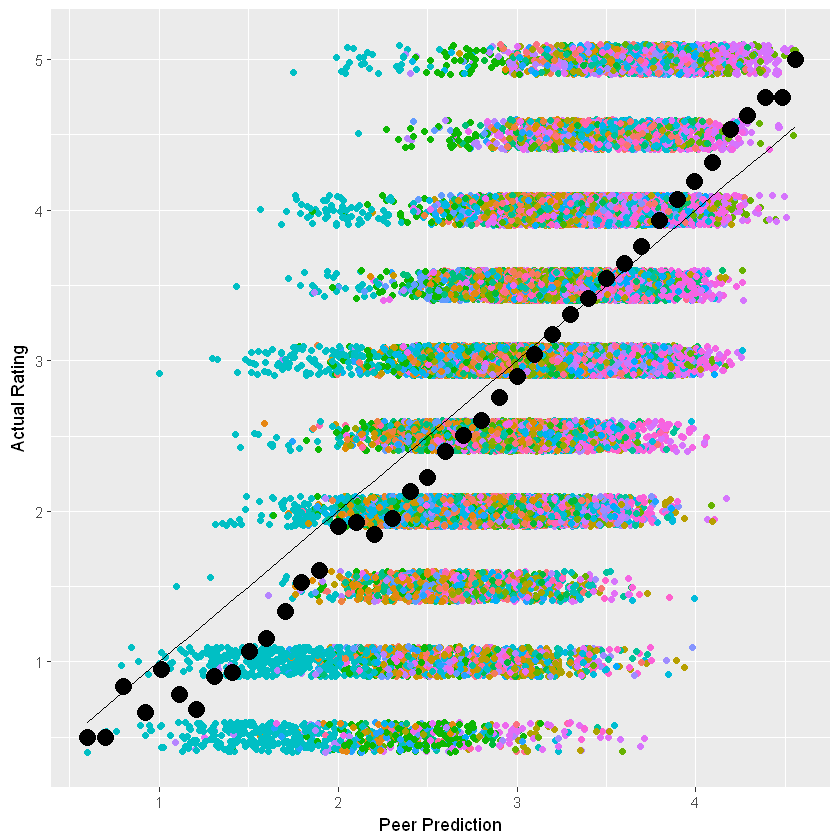

In [19]:
ggplot(ListOfPredictionsWithoutNans , aes(y=actualRating, x=weightedScore))+
geom_jitter(height = 0.1, width = 0, aes(color=as.factor(userId)))+stat_function(fun=function(x)x)+
geom_point(data=means, aes(x=meanPrediction,y=meanActualRating,size=2))+
theme(legend.position = "none")+xlab("Peer Prediction")+ylab("Actual Rating")

It looks like the model fits reasonably well. I expected the model to not fit perfectly at the ends, since the model is always going to effectively hedge it's bets. It won't predict a film is going to be a 0.5 star film since that would require it to have been universally panned by all  of the user's peers, and even then that might not be enough to encourage it to go all the way, depending on the strength of the fit.

In [20]:
merge(subset(movies, movieId %in% subset(ListOfPredictionsWithoutNans,     (weightedScore < 3 & actualRating == 5)  )$movieId),
      subset(ListOfPredictionsWithoutNans,     (weightedScore < 3 & actualRating == 5) 
            ))[c("movieId","userId","title","weightedScore","actualRating")][1:10,]

movieId,userId,title,weightedScore,actualRating
1,46470,Toy Story (1995),2.981780,5
25,46470,Leaving Las Vegas (1995),2.709189,5
34,74142,Babe (1995),2.163401,5
50,74142,"Usual Suspects, The (1995)",2.514911,5
123,114406,Chungking Express (Chung Hing sam lam) (1994),2.972128,5
537,83090,Sirens (1994),2.594878,5
539,46470,Sleepless in Seattle (1993),2.603372,5
551,74142,"Nightmare Before Christmas, The (1993)",2.064946,5
785,136268,Kingpin (1996),2.908149,5
912,46470,Casablanca (1942),2.851538,5


So as you can see above, the model isn't perfect. Like suggesting Casablanca would be rated below 3 stars.

I also considered modifying the model so that it only considers using the ratings of other users where the linear coefficient was large, i.e. only use recommendations from people who like the same thing rather than an influence from all people. In this way we wouldn’t get so much of the effect of ‘everyone likes this film so this user probably will’, but instead we get ‘people who liked what this person liked, liked this,so this person will’. 

The problem with this is that among the 48 power users, there were 20 who had no coefficient above 0.6 with any other power user and so for them this method would not work. The cost for what may be no improvement is simply not worth it. The next approach to improving this model would be to  use only highly correlated peers, but i would need more processing power than i have here.
